In [43]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-t3uiuhtb
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-t3uiuhtb
  Resolved https://github.com/albumentations-team/albumentations to commit e50ae0f40962c21a66576d99c5c2e6768d7b8189
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Download Full Dataset

Market-1501 dataset :
https://www.kaggle.com/pengcw1/market-1501

In [44]:
!git clone https://github.com/parth1620/Person-Re-Id-Dataset

fatal: destination path 'Person-Re-Id-Dataset' already exists and is not an empty directory.


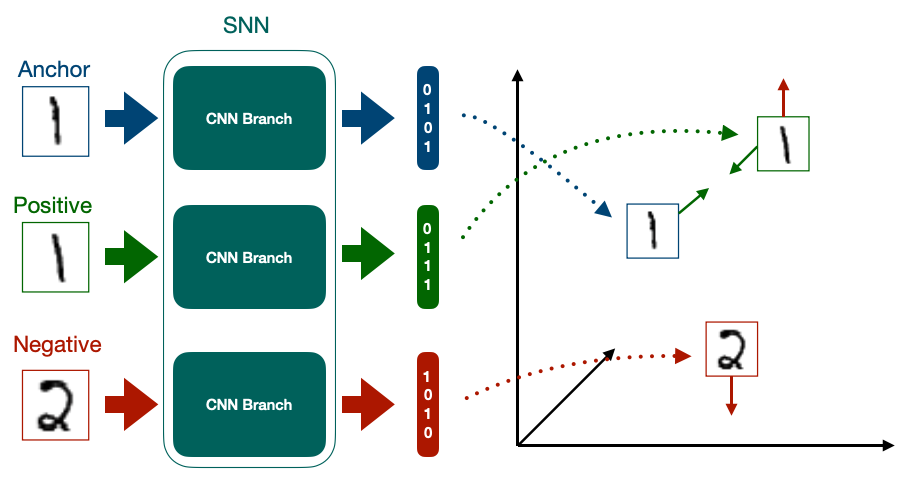

# Imports

In [45]:
import sys
sys.path.append('/content/Person-Re-Id-Dataset')

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import timm

import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader

from skimage import io
from sklearn.model_selection import train_test_split

from tqdm import tqdm

# Configurations

In [47]:
data_dir = '/content/Person-Re-Id-Dataset/train'
csv_file = '/content/Person-Re-Id-Dataset/train.csv'

batch_size = 32
lr = 0.001
epochs = 15

device = 'cuda'

In [48]:
df = pd.read_csv(csv_file)
df.head()

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


In [49]:
row = df.iloc[4]
A_img = io.imread(data_dir + '/' + row.Anchor)
P_img = io.imread(data_dir + '/' + row.Positive)
N_img = io.imread(data_dir + '/' + row.Negative)

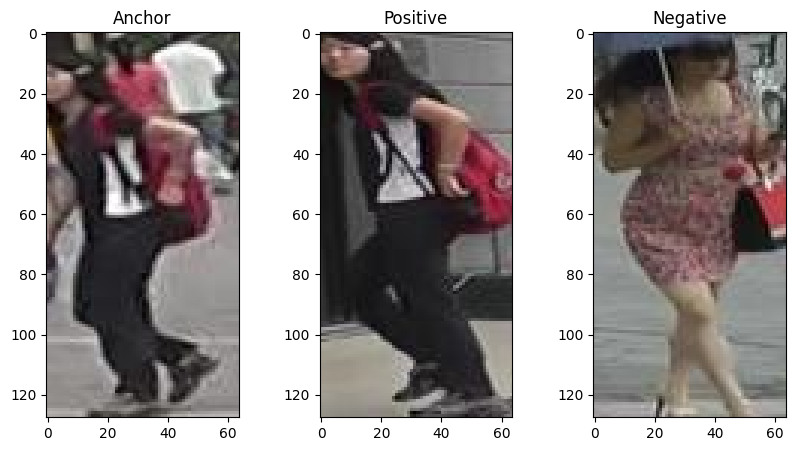

In [50]:
f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A_img)

ax2.set_title('Positive')
ax2.imshow(P_img)

ax3.set_title('Negative')
ax3.imshow(N_img)

In [51]:
train_df, valid_df = train_test_split(df, test_size = 0.2, random_state = 42)

# Create APN Dataset

In [52]:
class APN_Dataset(Dataset):
    def __init__(self, df):
      self.df = df
    def __len__(self):
      return len(self.df)
    def __getitem__(self, idx):
      row = self.df.iloc[idx]

      A_img = io.imread(data_dir + '/' + row.Anchor)
      P_img = io.imread(data_dir + '/' + row.Positive)
      N_img = io.imread(data_dir + '/' + row.Negative)

      A_img = torch.from_numpy(A_img).permute(2,0,1) / 255.0
      P_img = torch.from_numpy(P_img).permute(2,0,1) / 255.0
      N_img = torch.from_numpy(N_img).permute(2,0,1) / 255.0

      return A_img, P_img, N_img

In [53]:
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)

print(f"Length of trainset : {len(trainset)}")
print(f"Length of validset : {len(validset)}")

Length of trainset : 3200
Length of validset : 800


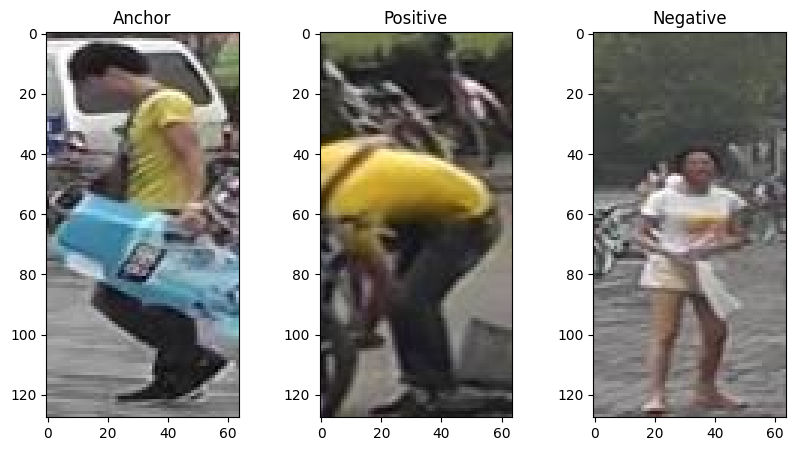

In [54]:
idx = 40
A,P,N = trainset[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

# Load Dataset into Batches

In [55]:
trainloader = DataLoader(trainset, batch_size = batch_size, shuffle = True)
validloader = DataLoader(validset, batch_size = batch_size)

In [56]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 100
No. of batches in validloader : 25


In [57]:
for A,P,N in trainloader:
  break;

print(f"One image batch shape : {A.shape}")

One image batch shape : torch.Size([32, 3, 128, 64])


# Create Model

In [58]:
class APN_Model(nn.Module):

  def __init__(self, emb_size = 512):
    super(APN_Model, self).__init__()
    self.efficientnet = timm.create_model('efficientnet_b0', pretrained = True)
    self.efficientnet.classifier = nn.Linear(in_features = self.efficientnet.classifier.in_features, out_features = emb_size)

  def forward(self, images):

    embeddings = self.efficientnet(images)
    return embeddings

In [59]:
model = APN_Model()
model.to(device)

APN_Model(
  (efficientnet): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size

# Create Train and Eval function

In [60]:
def train_fn(model, dataloader, optimizer, criterion):

  model.train()
  total_loss = 0.0

  for A, P, N in tqdm(dataloader):
    A = A.to(device)
    P = P.to(device)
    N = N.to(device)

    A_emb = model(A)
    P_emb = model(P)
    N_emb = model(N)

    loss = criterion(A_emb, P_emb, N_emb)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(dataloader)

In [61]:
def eval_fn(model, dataloader, criterion):

  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for A, P, N in tqdm(dataloader):
      A = A.to(device)
      P = P.to(device)
      N = N.to(device)

      A_emb = model(A)
      P_emb = model(P)
      N_emb = model(N)

      loss = criterion(A_emb, P_emb, N_emb)
      total_loss += loss.item()

    return total_loss / len(dataloader)

In [62]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

# Create Training Loop

In [63]:
best_valid_loss = np.Inf

for i in range(epochs):
  train_loss = train_fn(model, trainloader, optimizer, criterion)
  valid_loss = eval_fn(model, validloader, criterion)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    best_valid_loss = valid_loss
    print("Weights Saved")

    print(f"Epoch : {i+1} | Train Loss : {train_loss} | Valid Loss : {valid_loss}")

100%|██████████| 25/25 [00:03<00:00,  6.61it/s]


Weights Saved
Epoch : 1 | Train Loss : 0.6197377967834473 | Valid Loss : 0.5712105917930603


100%|██████████| 25/25 [00:04<00:00,  5.15it/s]


Weights Saved
Epoch : 2 | Train Loss : 0.3179646523296833 | Valid Loss : 0.3709059303998947


100%|██████████| 25/25 [00:04<00:00,  6.15it/s]


Weights Saved
Epoch : 3 | Train Loss : 0.1886567884683609 | Valid Loss : 0.23706094622612


100%|██████████| 25/25 [00:03<00:00,  7.32it/s]


Weights Saved
Epoch : 4 | Train Loss : 0.10058653384447097 | Valid Loss : 0.189138485789299


100%|██████████| 25/25 [00:03<00:00,  6.87it/s]


Weights Saved
Epoch : 9 | Train Loss : 0.08255557745695113 | Valid Loss : 0.18892525911331176


100%|██████████| 25/25 [00:03<00:00,  7.33it/s]


Weights Saved
Epoch : 10 | Train Loss : 0.05174904316663742 | Valid Loss : 0.13379043400287627


100%|██████████| 25/25 [00:03<00:00,  6.86it/s]


# Get Anchor Embeddings

In [64]:
import os
def get_encoding_csv(model, anc_img_names):
  anc_img_names_arr = np.array(anc_img_names)
  encodings = []

  model.eval()
  with torch.no_grad():
    for i in tqdm(anc_img_names_arr):

      if not os.path.exists(data_dir + i):
        print(f"File not found: {data_dir + i}")
        continue

      A = io.imread(data_dir + i)
      A = torch.from_numpy(A).permute(2,0,1) / 255.0
      A = A.to(device)
      A_enc = model(A.unsqueeze(0))
      encodings.append(A_enc.squeeze().cpu().detach().numpy())

  encodings = np.array(encodings)
  encodings = pd.DataFrame(encodings)
  df_enc = pd.concat([anc_img_names, encodings], axis = 1)
  encodings.to_csv('encodings.csv', index = False)

  return df_enc

In [42]:
model.load_state_dict(torch.load('best_model.pt'))
df_enc = get_encoding_csv(model, df['Anchor'])

<ipython-input-42-fb78bba7c639>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))
  8%|▊         | 312/4000 [00:00<00:01, 2

File not found: /content/Person-Re-Id-Dataset/train1420_c5s3_052165_01.jpg
File not found: /content/Person-Re-Id-Dataset/train1420_c3s3_061978_03.jpg
File not found: /content/Person-Re-Id-Dataset/train1420_c5s3_062565_05.jpg
File not found: /content/Person-Re-Id-Dataset/train1420_c6s3_085592_04.jpg
File not found: /content/Person-Re-Id-Dataset/train0663_c5s3_085987_03.jpg
File not found: /content/Person-Re-Id-Dataset/train0663_c6s4_011877_01.jpg
File not found: /content/Person-Re-Id-Dataset/train0663_c1s6_036721_09.jpg
File not found: /content/Person-Re-Id-Dataset/train0663_c3s3_085444_03.jpg
File not found: /content/Person-Re-Id-Dataset/train1078_c4s5_008004_01.jpg
File not found: /content/Person-Re-Id-Dataset/train1078_c2s2_141377_03.jpg
File not found: /content/Person-Re-Id-Dataset/train1078_c1s5_008761_01.jpg
File not found: /content/Person-Re-Id-Dataset/train1078_c2s2_141352_03.jpg
File not found: /content/Person-Re-Id-Dataset/train1230_c1s5_041241_08.jpg
File not found: /content/

 25%|██▌       | 1011/4000 [00:00<00:01, 2696.34it/s]

File not found: /content/Person-Re-Id-Dataset/train0208_c5s1_042176_04.jpg
File not found: /content/Person-Re-Id-Dataset/train0208_c5s2_097627_01.jpg
File not found: /content/Person-Re-Id-Dataset/train0208_c6s1_070651_02.jpg
File not found: /content/Person-Re-Id-Dataset/train1487_c1s6_047146_01.jpg
File not found: /content/Person-Re-Id-Dataset/train1487_c5s3_096287_02.jpg
File not found: /content/Person-Re-Id-Dataset/train1487_c6s4_022252_03.jpg
File not found: /content/Person-Re-Id-Dataset/train1487_c3s3_095694_01.jpg
File not found: /content/Person-Re-Id-Dataset/train1275_c1s5_052016_02.jpg
File not found: /content/Person-Re-Id-Dataset/train1275_c1s5_059516_02.jpg
File not found: /content/Person-Re-Id-Dataset/train1275_c3s3_032728_01.jpg
File not found: /content/Person-Re-Id-Dataset/train1275_c3s3_025903_02.jpg
File not found: /content/Person-Re-Id-Dataset/train0594_c6s2_013968_01.jpg
File not found: /content/Person-Re-Id-Dataset/train0594_c6s2_014068_01.jpg
File not found: /content/

 36%|███▌      | 1427/4000 [00:00<00:00, 3028.27it/s]

File not found: /content/Person-Re-Id-Dataset/train0579_c2s2_009212_01.jpg
File not found: /content/Person-Re-Id-Dataset/train0579_c6s2_006693_04.jpg
File not found: /content/Person-Re-Id-Dataset/train0375_c1s2_017991_01.jpg
File not found: /content/Person-Re-Id-Dataset/train0375_c1s2_016491_01.jpg
File not found: /content/Person-Re-Id-Dataset/train0375_c5s1_090698_04.jpg
File not found: /content/Person-Re-Id-Dataset/train0375_c5s1_090723_01.jpg
File not found: /content/Person-Re-Id-Dataset/train0104_c3s1_017076_02.jpg
File not found: /content/Person-Re-Id-Dataset/train0104_c6s1_018001_01.jpg
File not found: /content/Person-Re-Id-Dataset/train0104_c3s1_017426_02.jpg
File not found: /content/Person-Re-Id-Dataset/train0104_c6s1_018076_01.jpg
File not found: /content/Person-Re-Id-Dataset/train0224_c5s1_055848_02.jpg
File not found: /content/Person-Re-Id-Dataset/train0224_c3s1_046576_01.jpg
File not found: /content/Person-Re-Id-Dataset/train0224_c1s1_046901_01.jpg
File not found: /content/

 63%|██████▎   | 2532/4000 [00:00<00:00, 4076.71it/s]

File not found: /content/Person-Re-Id-Dataset/train0787_c3s2_088903_01.jpg
File not found: /content/Person-Re-Id-Dataset/train0787_c1s4_028481_02.jpg
File not found: /content/Person-Re-Id-Dataset/train0100_c1s1_016926_03.jpg
File not found: /content/Person-Re-Id-Dataset/train0100_c3s2_149294_01.jpg
File not found: /content/Person-Re-Id-Dataset/train0100_c1s1_016901_02.jpg
File not found: /content/Person-Re-Id-Dataset/train0100_c4s1_017226_02.jpg
File not found: /content/Person-Re-Id-Dataset/train0843_c2s2_104707_07.jpg
File not found: /content/Person-Re-Id-Dataset/train0843_c3s2_107203_06.jpg
File not found: /content/Person-Re-Id-Dataset/train0843_c3s2_107178_07.jpg
File not found: /content/Person-Re-Id-Dataset/train0843_c2s2_104732_05.jpg
File not found: /content/Person-Re-Id-Dataset/train1135_c5s2_161724_04.jpg
File not found: /content/Person-Re-Id-Dataset/train1135_c3s2_157944_01.jpg
File not found: /content/Person-Re-Id-Dataset/train1135_c3s2_158119_04.jpg
File not found: /content/

 74%|███████▍  | 2958/4000 [00:00<00:00, 4116.03it/s]

File not found: /content/Person-Re-Id-Dataset/train0688_c6s2_058418_04.jpg
File not found: /content/Person-Re-Id-Dataset/train0688_c1s4_009856_03.jpg
File not found: /content/Person-Re-Id-Dataset/train0688_c3s2_092878_01.jpg
File not found: /content/Person-Re-Id-Dataset/train1135_c1s5_022486_01.jpg
File not found: /content/Person-Re-Id-Dataset/train1135_c6s3_023042_01.jpg
File not found: /content/Person-Re-Id-Dataset/train1135_c3s2_158094_04.jpg
File not found: /content/Person-Re-Id-Dataset/train1135_c6s3_020042_03.jpg
File not found: /content/Person-Re-Id-Dataset/train0566_c3s2_013637_01.jpg
File not found: /content/Person-Re-Id-Dataset/train0566_c2s2_010937_01.jpg
File not found: /content/Person-Re-Id-Dataset/train0566_c3s2_004562_05.jpg
File not found: /content/Person-Re-Id-Dataset/train0566_c3s2_004562_03.jpg
File not found: /content/Person-Re-Id-Dataset/train0179_c1s6_029396_02.jpg
File not found: /content/Person-Re-Id-Dataset/train0179_c5s3_078512_01.jpg
File not found: /content/

 85%|████████▍ | 3383/4000 [00:01<00:00, 3223.81it/s]

File not found: /content/Person-Re-Id-Dataset/train0482_c3s1_125533_01.jpg
File not found: /content/Person-Re-Id-Dataset/train0482_c3s1_139183_03.jpg
File not found: /content/Person-Re-Id-Dataset/train1263_c3s3_022878_04.jpg
File not found: /content/Person-Re-Id-Dataset/train1263_c1s5_049216_04.jpg
File not found: /content/Person-Re-Id-Dataset/train1263_c4s5_049660_02.jpg
File not found: /content/Person-Re-Id-Dataset/train1263_c1s5_049391_03.jpg
File not found: /content/Person-Re-Id-Dataset/train0110_c2s1_018026_01.jpg
File not found: /content/Person-Re-Id-Dataset/train0110_c5s1_035201_01.jpg
File not found: /content/Person-Re-Id-Dataset/train0110_c4s1_035126_01.jpg
File not found: /content/Person-Re-Id-Dataset/train0110_c6s1_019001_01.jpg
File not found: /content/Person-Re-Id-Dataset/train0069_c6s3_087992_01.jpg
File not found: /content/Person-Re-Id-Dataset/train0069_c2s3_057977_03.jpg
File not found: /content/Person-Re-Id-Dataset/train0069_c2s3_058002_02.jpg
File not found: /content/

100%|██████████| 4000/4000 [00:01<00:00, 2955.73it/s]

File not found: /content/Person-Re-Id-Dataset/train0434_c5s1_106348_03.jpg
File not found: /content/Person-Re-Id-Dataset/train0616_c1s3_047876_01.jpg
File not found: /content/Person-Re-Id-Dataset/train0616_c2s2_016637_02.jpg
File not found: /content/Person-Re-Id-Dataset/train0616_c1s3_047451_03.jpg
File not found: /content/Person-Re-Id-Dataset/train0616_c2s2_016637_02.jpg
File not found: /content/Person-Re-Id-Dataset/train1011_c6s2_124593_05.jpg
File not found: /content/Person-Re-Id-Dataset/train1011_c6s2_124543_05.jpg
File not found: /content/Person-Re-Id-Dataset/train1011_c6s2_124593_05.jpg
File not found: /content/Person-Re-Id-Dataset/train1011_c6s2_124543_05.jpg
File not found: /content/Person-Re-Id-Dataset/train0529_c5s1_154770_04.jpg
File not found: /content/Person-Re-Id-Dataset/train0529_c3s1_148583_02.jpg
File not found: /content/Person-Re-Id-Dataset/train0529_c2s1_148341_04.jpg
File not found: /content/Person-Re-Id-Dataset/train0529_c3s1_148608_02.jpg
File not found: /content/

In [66]:
df_enc.to_csv('database.csv', index = False)
df_enc.head()

,Anchor,0
0,1420_c5s3_052165_01.jpg,NaN
1,1420_c3s3_061978_03.jpg,NaN
2,1420_c5s3_062565_05.jpg,NaN
3,1420_c6s3_085592_04.jpg,NaN
4,0663_c5s3_085987_03.jpg,NaN


from matplotlib import pyplot as plt
import seaborn as sns
_df_0.groupby('Anchor').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

# Inference

In [67]:
def euclidean_distance(img_enc, anc_enc_arr):
  dist = np.sqrt(np.dot(img_enc-anc_enc_arr, (img_enc - anc_enc_arr).T))
  return dist

In [69]:
idx = 0
img_name = df_enc['Anchor'].iloc[idx]
img_path = data_dir + '/' + img_name

img = io.imread(img_path)
img = torch.from_numpy(img).permute(2,0,1) / 255.0

model.eval()
with torch.no_grad():
  img = img.to(device)
  img_enc = model(img.unsqueeze(0))
  img_enc = img_enc.detach().cpu().numpy()

In [70]:
anc_enc_arr = df_enc.iloc[:, 1:].to_numpy()
anc_img_names = df_enc['Anchor']

In [81]:
distance = []

for i in range(anc_enc_arr.shape[0]):
  dist = euclidean_distance(img_enc, anc_enc_arr[i : i+1, :])
  distance.append(dist)

In [82]:
closest_idx = np.argsort(distance)

In [83]:
from utils import plot_closest_imgs

plot_closest_imgs(anc_img_names, data_dir, img, img_path, closest_idx, distance, no_of_closest = 5);

ValueError: Buffer has wrong number of dimensions (expected 1, got 2)